In [2]:
import os
import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
import pickle

In [4]:
data_folder = "//storage.corp.brain.mpg.de/data/Projects/Fritz_Lukas/trex_videos/data"
file_list = pd.Series(os.listdir(data_folder))
file_list.columns =  ["files"]

# filter for tracking data (statistics folder not relevant for now)
fish_id = file_list.str.contains("fish")
file_list_filtered = file_list.loc[fish_id]

# identify genotypes and number of videos for each, save as dictionary.
string_split_list = pd.DataFrame(file_list_filtered.str.split("_"))
string_split_list.columns = ["split_string"]
id_df = pd.DataFrame(string_split_list.split_string.tolist(), columns = ['genotype', 'video', 'fish'])
genotypes = id_df['genotype'].unique()
for genotype in genotypes:
    genotype_videos = []
    videos = id_df.loc[id_df['genotype'] == genotype]['video'].unique()
    if 'data_dict' not in locals():
        data_dict = {genotype: videos.tolist()}
        fish = id_df.loc[id_df['genotype'] == genotype]['fish'].unique().tolist()
    else:
        data_dict.update({genotype: videos.tolist()})
    
                      

In [5]:
for genotype in genotypes:
    print(data_dict[genotype])

['1']
['1', '2', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '3', '4', '5', '6', '7', '8']
['1', '2', '10', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '4', '5', '6', '7', '8', '9']
['1', '3', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '4', '5', '6', '7', '8', '9']
['1', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '4', '5', '6', '7', '8', '9']


In [24]:
# heatmap
# individual velocity
# mean velocity
# LOOCV
# tracking reliability
# example trajectories
# shoaling vs schooling
plot_trajectories = 0

In [25]:
range_a = range(0,53970,30)
range_b = range(30,54000,30)

for genotype in genotypes: 
    videos2analyse = data_dict[genotype]
    for video in videos2analyse:
        print('Analysis of: ' + str(genotype) + ', video ' + str(video))
        trajectories = np.empty(54000*20*2).reshape(54000,20,2)
        bodylengths = np.empty(20)
        velocity = np.empty(54000*20).reshape(54000,20)
        fish_id = 0
        for fishID in fish:
            file2load = data_folder + '/' + str(genotype) + '_' + str(video) + '_' + fishID 

            fish_df = np.load(file2load)
            bodylengths[fish_id] = np.median(fish_df['midline_length'])
            df_length = (np.shape(fish_df['X']))[0]
            if df_length != 54000:
                N = 54000 - df_length
                x = np.append(fish_df['X'], np.repeat(np.nan, N))
                y = np.append(fish_df['Y'], np.repeat(np.nan, N))
                trajectories[:,fish_id,0] = x
                trajectories[:,fish_id,1] = y
                velocity[:,fish_id] = np.append(fish_df['SPEED'], np.repeat(np.nan, N))
            else:
                trajectories[:,fish_id,0] = fish_df['X']
                trajectories[:,fish_id,1] = fish_df['Y']
                velocity[:,fish_id] = fish_df['SPEED']
            fish_id += 1
        if plot_trajectories:
            y = 0
            fig,ax = plt.subplots(figsize=(20,10), nrows=3, ncols=7)
            ax[2, 6].plot(trajectories[:,:,0], trajectories[:,:,1], linewidth=0.01)
            i = 0
            for x in range(3):
                for y in range(7):
                    ax[x,y].plot(trajectories[:,i,0], trajectories[:,i,1], linewidth = 0.1)
                    ax[x,y].axis('off')
                    ax[x,y].set_title('Fish ' + str(i+1), fontsize = 14, fontweight ='bold') 
                    i += 1
                    if i == 20:
                        break
            plt.axis('off') 
            save_string = genotype + '_' + video + '.png'
            plt.savefig(save_string)

        velocity_median = np.nanmedian(velocity, axis = 1)
        # sum up velocity to every second    
        vel_sec = [np.nansum(velocity_median[i-30:i]) for i in range(30,54000,30)]
        # perform analysis of distance between fish and polarity:
        # distance over time
        neighbor_distance = np.empty(1800)
        neighbor_min = np.empty(1800)
        a = 0
        for frame in range(0,54000,30): # adapt to every second
            positionMatrix = pd.DataFrame([trajectories[frame,:,0], trajectories[frame,:,1]]).transpose()
            trialMatrix = pd.DataFrame(distance.squareform(distance.pdist(positionMatrix)))
            trialMatrix[trialMatrix==0]=np.nan  # set to nan, otherwise the min will identify the same animal.
            neighbor_distance[a] = np.nanmedian(trialMatrix)
            neighbor_min[a] = np.median(np.min(trialMatrix))
            a += 1
        # polarity of animals over time 
        dx = trajectories[range_b,:,0] - trajectories[range_a,:,0]
        dy = trajectories[range_b,:,1] - trajectories[range_a,:,1]
        v0 = np.nansum(((dx**2 + dy**2)**0.5), axis = 1)/(20 - np.sum(np.isnan(dx), axis = 1)) # average absolute velocity normalized by number of fish
        rho = (((np.nansum(dx, axis = 1)**2) + (np.nansum(dy, axis = 1)**2))**0.5) /(v0*(20 - np.sum(np.isnan(dx), axis = 1)))

        # save to dictionary:
        if 'analysis_dict' not in locals():
            analysis_dict = {genotype: {video: {'velocity': vel_sec, 
                                                'nearestneighbor': neighbor_min, 
                                                'neighbor': neighbor_distance, 
                                                'rho': rho,
                                               'trajectory': trajectories}}}
        elif genotype not in analysis_dict:
            analysis_dict[genotype] = {video: {'velocity': vel_sec, 
                                               'nearestneighbor': neighbor_min, 
                                               'neighbor': neighbor_distance, 
                                               'rho': rho,
                                              'trajectory': trajectories}}
        else:
            analysis_dict[genotype][video] = {'velocity': vel_sec, 
                                              'nearestneighbor': neighbor_min, 
                                              'neighbor': neighbor_distance, 
                                              'rho': rho,
                                             'trajectory': trajectories}
    

#output = open('TRex_analysis.pkl', 'wb')
#pickle.dump(analysis_dict, output)
#output.close()



Analysis of: pth2w, video 1


C:\Users\anneserl\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
C:\Users\anneserl\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in subtract
C:\Users\anneserl\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in subtract
C:\Users\anneserl\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\anneserl\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Analysis of: ILR1K, video 1
Analysis of: ILR1K, video 2
Analysis of: ILR1K, video 10
Analysis of: ILR1K, video 11
Analysis of: ILR1K, video 12
Analysis of: ILR1K, video 13
Analysis of: ILR1K, video 14
Analysis of: ILR1K, video 15
Analysis of: ILR1K, video 16
Analysis of: ILR1K, video 17
Analysis of: ILR1K, video 18
Analysis of: ILR1K, video 19
Analysis of: ILR1K, video 20
Analysis of: ILR1K, video 21
Analysis of: ILR1K, video 22
Analysis of: ILR1K, video 23
Analysis of: ILR1K, video 3
Analysis of: ILR1K, video 4
Analysis of: ILR1K, video 5
Analysis of: ILR1K, video 6
Analysis of: ILR1K, video 7
Analysis of: ILR1K, video 8
Analysis of: ILR1w, video 1
Analysis of: ILR1w, video 2
Analysis of: ILR1w, video 10
Analysis of: ILR1w, video 12
Analysis of: ILR1w, video 13
Analysis of: ILR1w, video 14
Analysis of: ILR1w, video 15
Analysis of: ILR1w, video 16
Analysis of: ILR1w, video 17
Analysis of: ILR1w, video 18
Analysis of: ILR1w, video 19
Analysis of: ILR1w, video 20
Analysis of: ILR1w, vide

In [26]:
output = open('TRex_analysis.pkl', 'wb')
pickle.dump(analysis_dict, output)
output.close()


In [27]:
analysis_df = pd.DataFrame.from_dict({(i,j): analysis_dict[i][j] 
                           for i in analysis_dict.keys() 
                           for j in analysis_dict[i].keys()},
                       orient='index')


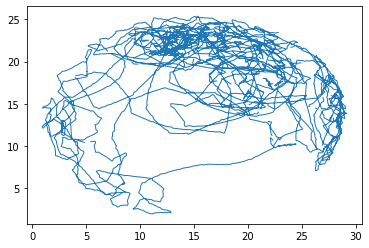

In [21]:
plt.plot(analysis_df['trajectory'][0][44000:54000,1,0], analysis_df['trajectory'][0][44000:54000,1,1], linewidth = 1)

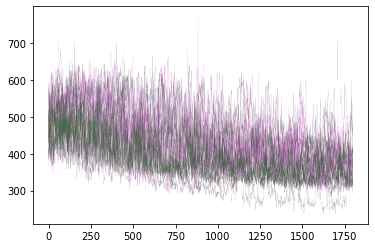

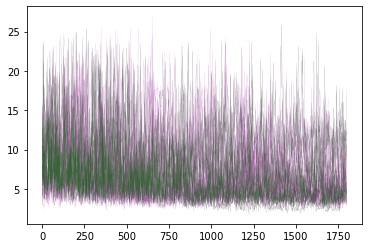

In [134]:
for item in analysis_df['velocity']['ILR1K']:
    plt.plot(item, 'm', linewidth = 0.05)
for item in analysis_df['velocity']['ILR1w']:
    plt.plot(item, 'g', linewidth = 0.05)
    
plt.show()

for item in analysis_df['neighbor']['ILR1K']:
    plt.plot(item, 'm', linewidth = 0.05)
for item in analysis_df['neighbor']['ILR1w']:
    plt.plot(item, 'g', linewidth = 0.05)
    
plt.show()

In [28]:
analysis_df.to_pickle('TRex_analysis_pd.pkl')